In [1]:
# import packages here to reduce the size of code cells later

import pandas as pd
from prettypandas import PrettyPandas
import patsy

import numpy as np
import scipy.stats
import statsmodels.formula.api
import statsmodels.api as sm

from graphviz import Digraph
import seaborn as sns

import dexpy.factorial
import dexpy.alias
import dexpy.power

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import patches

from IPython.display import display, Markdown, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
# CSV Results Layout and File

columns = ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'cost', 'time', 'quality', 'comment']

cr6_print_history = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6-doe-schedule.csv', skiprows=1, names=columns)

In [3]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

# Motivating Example: Better Office Coffee

 * 5 input factors
  * lh of Coffee (2.5 to 4.0 oz.)
  * Grind size (8-10mm)
  * Brew time (3.5 to 4.5 minutes)
  * Grind Type (burr vs blade)
  * Coffee wt (light vs dark)
 * 1 response: Average overall liking by a panel of 5 office coffee addicts
  * Each taster rates the coffee from 1-9
 * Maximum of 3 taste tests a day, for liability reasons
 

In [4]:
# Layer Thickness = lh
lh_low = .16 
lh_hi = .24 

# Print Speed = ps
ps_low = 50 
ps_hi = 60 

# Infill Density = id
id_low = .25 
id_hi = .15 

# Raster Width = rw
rw_low = .4 
rw_hi = .8 

# Wall Thicknessv = wt
wt_low = 1.2 
wt_hi = .8

In [5]:
# set some variables related to the coffee data set
actual_lows = { 'lh' : lh_low, 'ps' : ps_low, 'id': id_low, 'rw': rw_low, 'wt': wt_low }
actual_highs = { 'lh' : lh_hi, 'ps' : ps_hi, 'id': id_hi, 'rw': rw_hi, 'wt': wt_hi }
units = { 'lh' : 'mm', 'ps' : 'mm/s', 'id': '%', 'rw': 'mm', 'wt': 'mm' }

# Fractional Factorials

* Coffee experiment is 2<sup>5</sup> runs (32)
* We want to add 4 center point runs to check for curvature
* Total runs = 36, 3 per day if all testers are in the office
* Estimate experiment will take a month

# Fractional Factorials
* Power for the experiment is > 99%
* Full factorial is overkill
* Instead run 2<sup>5-1</sup> experiments, a "half fraction"


# Fractional Factorials in dexpy

https://statease.github.io/dexpy/design-build.html#module-dexpy.factorial

In [6]:
help(dexpy.factorial.build_factorial)

Help on function build_factorial in module dexpy.factorial:

build_factorial(factor_count, run_count)
    Builds a regular two-level design based on a number of factors and runs.
    
    Full two-level factorial designs may be run for up to 9 factors. These
    designs permit estimation of all main effects and all interaction effects.
    If the number of runs requested is a 2^factor_count, the design will be a
    full factorial.
    
    If the number of runs is less than 2^factor_count (it still must be a power
    of two) a fractional design will be created. Not all combinations of runs
    and factor counts will result in a design. Use the
    :ref:`alias list<alias-list>` method to see what terms are estimable in
    the resulting design.
    
    :param factor_count: The number of factors to build for.
    :type factor_count: int
    :param run_count: The number of runs in the resulting design. Must be a power of 2.
    :type run_count: int
    :returns: A pandas.DataFrame obje

In [7]:


# cr6_print_history = dexpy.factorial.build_factorial(5, 2**(5-1))
# cr6_print_history.columns = ['lh', 'ps', 'id', 'rw', 'wt']
center_points = [
]

#columns = ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'cost', 'time', 'quality', 'comment']

#cr6_print_history = pd.read_csv('file:///Users/wilsonm/Dropbox%20(APSU%20GIS)/Projects%20(DB)/Dissertation/3DP_Experiments/Data/cr6-doe-schedule.csv', skiprows=1, names=columns)

#cr6_print_history = cr6_print_history.append(pd.DataFrame(center_points * 2, columns=cr6_print_history.columns))
cr6_print_history.index = np.arange(0, len(cr6_print_history))

display(Markdown("## 2<sup>(5-1)</sup> Factorial Design"))
display(PrettyPandas(cr6_print_history))

actual_design = coded_to_actual(cr6_print_history, actual_lows, actual_highs)
cr6_print_actual = actual_design
display(Markdown("Actual ## 2<sup>(5-1)</sup> Factorial Design"))
display(PrettyPandas(actual_design))

## 2<sup>(5-1)</sup> Factorial Design

,trial,lh,ps,id,rw,wt,cost,time,quality,comment
0,1,-1,-1,-1,-1,1,0.510000,8746.000000,1,nan
1,2,1,-1,-1,-1,-1,0.504000,17946.000000,1,nan
2,3,-1,1,-1,-1,-1,0.540000,14449.600000,1,nan
3,4,1,1,-1,-1,1,0.510000,10178.600000,1,nan
4,5,-1,-1,1,-1,-1,0.540000,14987.200000,1,nan
5,6,1,-1,1,-1,1,0.500000,10362.000000,1,nan
6,7,-1,1,1,-1,1,0.500000,16635.200000,1,nan
7,8,1,1,1,-1,-1,0.540000,8838.600000,1,nan
8,9,-1,-1,-1,1,-1,0.540000,15108.200000,1,nan
9,10,1,-1,-1,1,1,0.560000,10623.400000,1,nan


Actual ## 2<sup>(5-1)</sup> Factorial Design

,trial,lh,ps,id,rw,wt,cost,time,quality,comment
0,1,0.160000,50.000000,0.250000,0.400000,0.800000,0.510000,8746.000000,1,nan
1,2,0.240000,50.000000,0.250000,0.400000,1.200000,0.504000,17946.000000,1,nan
2,3,0.160000,60.000000,0.250000,0.400000,1.200000,0.540000,14449.600000,1,nan
3,4,0.240000,60.000000,0.250000,0.400000,0.800000,0.510000,10178.600000,1,nan
4,5,0.160000,50.000000,0.150000,0.400000,1.200000,0.540000,14987.200000,1,nan
5,6,0.240000,50.000000,0.150000,0.400000,0.800000,0.500000,10362.000000,1,nan
6,7,0.160000,60.000000,0.150000,0.400000,0.800000,0.500000,16635.200000,1,nan
7,8,0.240000,60.000000,0.150000,0.400000,1.200000,0.540000,8838.600000,1,nan
8,9,0.160000,50.000000,0.250000,0.800000,1.200000,0.540000,15108.200000,1,nan
9,10,0.240000,50.000000,0.250000,0.800000,0.800000,0.560000,10623.400000,1,nan


In [8]:
# Transform DOE Schedule CSV dataframe to only include parameters

myDoE = cr6_print_history[['lh', 'ps', 'id', 'rw', 'wt']]
myDoE2 = cr6_print_actual[['lh', 'ps', 'id', 'rw', 'wt']]

### Cost Calculating Aliases in dexpy

In [9]:
cr6_alias = cr6_print_history[['lh', 'ps', 'id', 'rw', 'wt']]

# Analysis

* [statsmodels](http://statsmodels.sourceforge.net/) has lots of routines for modeling data
* We will use [Ordinary Least Squares (OLS)](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html) to fit
* `statsmodels` typically takes `numpy` arrays for X and y data
* It also has a "formulas" api that accepts a `patsy` formula

## Cost Analysis

In [10]:
cr6_cost_analysis = cr6_print_history[['lh', 'ps', 'id', 'rw', 'wt', 'cost']]
cr6_cost_analysis2 = cr6_print_actual[['lh', 'ps', 'id', 'rw', 'wt', 'cost']]
display(cr6_cost_analysis2)

,lh,ps,id,rw,wt,cost
0,0.16,50.0,0.25,0.4,0.8,0.510
1,0.24,50.0,0.25,0.4,1.2,0.504
2,0.16,60.0,0.25,0.4,1.2,0.540
3,0.24,60.0,0.25,0.4,0.8,0.510
4,0.16,50.0,0.15,0.4,1.2,0.540
5,0.24,50.0,0.15,0.4,0.8,0.500
6,0.16,60.0,0.15,0.4,0.8,0.500
7,0.24,60.0,0.15,0.4,1.2,0.540
8,0.16,50.0,0.25,0.8,1.2,0.540
9,0.24,50.0,0.25,0.8,0.8,0.560


In [11]:
y_cost = cr6_cost_analysis['cost']
X = cr6_cost_analysis[['lh', 'ps', 'id', 'rw', 'wt']]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
cost_results = sm.OLS(y_cost, X).fit()
cost_results.summary()

print(cost_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     2.883
Date:                Sat, 26 Jun 2021   Prob (F-statistic):             0.0617
Time:                        11:52:22   Log-Likelihood:                 53.359
No. Observations:                  18   AIC:                            -94.72
Df Residuals:                      12   BIC:                            -89.38
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5302      0.004    147.133      0.0

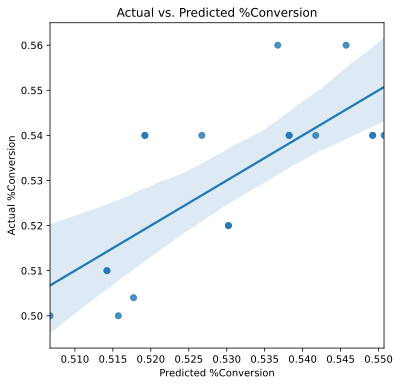

In [12]:
PlotWidth = 6
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=cost_results.predict(X), y=y_cost)
plt.xlabel('Predicted %Conversion')
plt.ylabel('Actual %Conversion')
plt.title('Actual vs. Predicted %Conversion')
plt.show()

In [13]:
display(cr6_cost_analysis)

,lh,ps,id,rw,wt,cost
0,-1,-1,-1,-1,1,0.510
1,1,-1,-1,-1,-1,0.504
2,-1,1,-1,-1,-1,0.540
3,1,1,-1,-1,1,0.510
4,-1,-1,1,-1,-1,0.540
5,1,-1,1,-1,1,0.500
6,-1,1,1,-1,1,0.500
7,1,1,1,-1,-1,0.540
8,-1,-1,-1,1,-1,0.540
9,1,-1,-1,1,1,0.560


In [14]:
# Working Models
# quantreg
# poisson
# 

lm = statsmodels.formula.api.ols("cost ~(lh + ps + id + rw + wt)**2", data=cr6_cost_analysis).fit()
print(lm.summary())



                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     3.369
Date:                Sat, 26 Jun 2021   Prob (F-statistic):              0.253
Time:                        11:52:22   Log-Likelihood:                 75.672
No. Observations:                  18   AIC:                            -119.3
Df Residuals:                       2   BIC:                            -105.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5302      0.003    207.478      0.0

In [15]:
reduced_model = "rw"
lm = statsmodels.formula.api.ols("cost ~" + reduced_model, data=cr6_cost_analysis).fit()
print(lm.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.439     
Dependent Variable: cost             AIC:                -100.0183 
Date:               2021-06-26 11:52 BIC:                -98.2376  
No. Observations:   18               Log-Likelihood:     52.009    
Df Model:           1                F-statistic:        14.32     
Df Residuals:       16               Prob (F-statistic): 0.00163   
R-squared:          0.472            Scale:              0.00020369
---------------------------------------------------------------------
              Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
---------------------------------------------------------------------
Intercept     0.5302     0.0034   157.6176   0.0000   0.5231   0.5374
rw            0.0135     0.0036     3.7836   0.0016   0.0059   0.0211
-------------------------------------------------------------------
Omnibus:                2.958        Durbin-Watson:     

# Visualization

* [seaborn](http://seaborn.pydata.org/) is built on top of `matplotlib` and adds support for `pandas` dataframes 
* Can build a plot using `seaborn`, then manipulate it with `matplotlib`
* Default themes look a lot nicer than what you get from `matplotlib` out of the box


If we take the experiment data from the design and use our new model to fit that data, then plot it against
the observed values we can get an idea for how well our model predicts. Points above the 45 degree line are
overpredicting for that combination of inputs. Points below the line predict a lower taste rating than
we actually measured during the experiment.

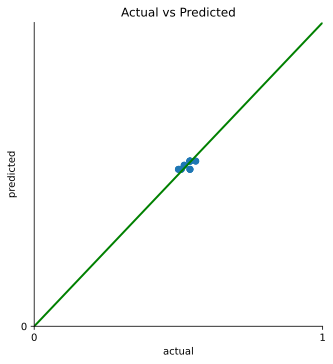

In [16]:
display(Markdown('''
If we take the experiment data from the design and use our new model to fit that data, then plot it against
the observed values we can get an idea for how well our model predicts. Points above the 45 degree line are
overpredicting for that combination of inputs. Points below the line predict a lower taste rating than
we actually measured during the experiment.'''))

actual_predicted = pd.DataFrame({ 'actual': cr6_print_history['cost'],
                                  'predicted': lm.fittedvalues
                                }, index=np.arange(len(cr6_cost_analysis['cost'])))
fg = sns.FacetGrid(actual_predicted, height=5)
fg.map(plt.scatter, 'actual', 'predicted')
ax = fg.axes[0, 0]
ax.plot([0, 1], [0, 1], color='g', lw=2)
ax.set_xticks(np.arange(0, 1.5))
ax.set_xlim([0, 1.])
ax.set_yticks(np.arange(0, 1))
ax.set_title('Actual vs Predicted')
_ = ax.set_ylim([0, 1])


Plotting the prediction for two factors at once shows how they interact with each other.
In this graph you can see that at the low brew time the larger grind size results in
a poor taste rating, likely because the coffee is too weak.

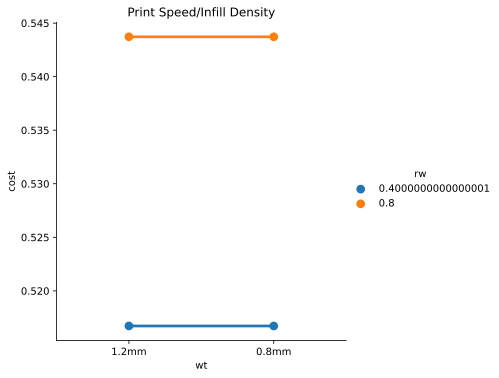

In [20]:
display(Markdown('''
Plotting the prediction for two factors at once shows how they interact with each other.
In this graph you can see that at the low brew time the larger grind size results in
a poor taste rating, likely because the coffee is too weak.'''))

pred_points = pd.DataFrame(1, columns = cr6_cost_analysis.columns, index=np.arange(4))
pred_points.loc[1,'wt'] = -1
pred_points.loc[3,'wt'] = -1
pred_points.loc[2,'rw'] = -1
pred_points.loc[3,'rw'] = -1
pred_points['cost'] = lm.predict(pred_points)
pred_points = coded_to_actual(pred_points, actual_lows, actual_highs)

fg = sns.factorplot('wt', 'cost', hue='rw', kind='point', data=pred_points)
ax = fg.axes[0, 0]
ax.set_xticklabels(get_tick_labels('wt', actual_lows, actual_highs, units))
_ = ax.set_title('Print Speed/Infill Density')

In [18]:
display(Markdown('''
This graph contains the prediction with the highest taste rating, 7.72.
However, if you look at the dark bean line there is a point where we can get
a rating of 6.93 with 2.5oz of grounds.
'''))

pred_points = pd.DataFrame(1, columns = cr6_cost_analysis.columns, index=np.arange(4))
pred_points.loc[1,'lh'] = -1
pred_points.loc[3,'lh'] = -1
pred_points.loc[2,'wt'] = -1
pred_points.loc[3,'wt'] = -1
pred_points['cost'] = lm.predict(pred_points)
pred_points = coded_to_actual(pred_points, actual_lows, actual_highs)

fg = sns.factorplot('lh', 'cost', hue='wt', kind='point', palette={'dark': 'maroon', 'light': 'peru'}, data=pred_points)
ax = fg.axes[0, 0]
ax.set_xticklabels(get_tick_labels('lh', actual_lows, actual_highs, units))
ax.set_title('lh/wt Interaction')
plt.show()

display(PrettyPandas(pred_points))
display(Markdown('''That savings of 1.5oz per pot would create a nice surplus in the coffee budget at the end of the year.'''))


This graph contains the prediction with the highest taste rating, 7.72.
However, if you look at the dark bean line there is a point where we can get
a rating of 6.93 with 2.5oz of grounds.


KeyError: 0.8

![coffeemaker](img/coffee_maker.jpg)

# The End

* We were able to build and execute an experiment in Python that resulted in a better tasting (and cheaper!) coffee.
* These slides can be found at https://hpanderson.github.io/dexpy-pymntos
* The jupyter notebook they are based on can be found on my github: https://github.com/hpanderson/dexpy-pymntos
* You can reach me at: <hank@statease.com>
* The `dexpy` docs are at: https://statease.github.io/dexpy/
* `dexpy` is only at version 0.1, we plan on greatly expanding the design and analysis capabilities
 